In [16]:
import sys,os
__script_path=os.path.abspath(globals().get('__file__','.'))
__script_dir = os.path.dirname(__script_path)
root_dir = os.path.abspath(f'{__script_dir}/../../')
print(root_dir)
for lib in [root_dir][::-1]:
    if lib in sys.path:
        sys.path.remove(lib)
    sys.path.insert(0,lib)



e:\User\PC\ads_enefit_ueh\ads_enfit


In [17]:
from libs.common import *
from config.config import *

In [18]:
if os.path.exists(exps_dir) == False: # tạo thư mục (nếu chưa có)
  os.makedirs(exps_dir, exist_ok=True)

save_dir = f"{exps_dir}/exp"
os.makedirs(save_dir, exist_ok=True)

In [19]:
plt.style.use(f'{style_dir}/style.mplstyle')
shap.initjs()

In [20]:
wandb.init(project="enefit_prediction_consumer")


In [21]:
ndays=1
X=pd.read_csv(f'{save_dir}/X_train_lag{ndays}_pre_processing.csv', index_col=None)
y=pd.read_csv(f'{save_dir}/y_train_lag{ndays}_pre_processing.csv', index_col=None)
X_train=pd.read_csv(f'{save_dir}/X_train_train_lag{ndays}_pre_processing.csv', index_col=None)
X_valid=pd.read_csv(f'{save_dir}/X_valid_train_lag{ndays}_pre_processing.csv', index_col=None)
y_train=pd.read_csv(f'{save_dir}/y_train_train_lag{ndays}_pre_processing.csv', index_col=None)
y_valid=pd.read_csv(f'{save_dir}/y_valid_train_lag{ndays}_pre_processing.csv', index_col=None)
scaler_y=joblib.load(f'{save_dir}/scaler_y.pkl')
best_params = dict(np.load(f'{save_dir}/best_params_.npz',allow_pickle=True))
target_valid=pd.read_csv(f'{save_dir}/target_valid{ndays}_pre_processing.csv', index_col=None)
target_valid.drop(columns=['Unnamed: 0'], inplace=True)


In [22]:
X.drop(columns=['Unnamed: 0'], inplace=True)
y.drop(columns=['Unnamed: 0'], inplace=True)
X_train.drop(columns=['Unnamed: 0'], inplace=True)
X_valid.drop(columns=['Unnamed: 0'], inplace=True)
y_train.drop(columns=['Unnamed: 0'], inplace=True)
y_valid.drop(columns=['Unnamed: 0'], inplace=True)
print(X_train.shape, y_train.shape, X_valid.shape, y_valid.shape)

(1086844, 102) (1086844, 1) (535312, 102) (535312, 1)


In [23]:
def r2(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [24]:
early_stopping = EarlyStopping(monitor='val_loss',
                                mode='min',
    min_delta=0.00005,
    patience=15,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    mode='min',
    factor=0.5,
    patience=6,
    min_lr=0.000001,
    verbose=1,
)
checkpoint_callback = ModelCheckpoint(
    filepath='best_model_cnn_mlps_no_weights.weights.h5',  # Đường dẫn để lưu model
    monitor='val_loss',  # Theo dõi val_loss
    mode='min',
    save_best_only=True,  # Lưu lại chỉ model có val_loss tốt nhất
    verbose=1,  # Hiển thị thông báo khi lưu model
    save_format="tf"
)

In [25]:
class CNNEncoding:
    def __init__(self, input_shape):
        self.input_shape = input_shape
        self.features = None
        self.model = self.build_model()
        
    def build_model(self):
        inputs = Input(shape=self.input_shape)
        x = Conv1D(32, 3, activation='selu')(inputs)
        self.features = MaxPooling1D(2)(x)
        x = Flatten()(self.features)
        x = Dense(1024, activation='selu')(x)
        x=BatchNormalization()(x)
        x=Dropout(0.5)(x)
        x = Dense(512, activation='selu')(x)
        x=BatchNormalization()(x)
        x=Dropout(0.5)(x)
        x = Dense(256, activation='selu')(x)
        x=BatchNormalization()(x)
        x=Dropout(0.5)(x)
        x = Dense(64, activation='selu')(x)
        x=BatchNormalization()(x)
        x=Dropout(0.5)(x)
        x = Dense(32, activation='selu')(x)
        x=BatchNormalization()(x)
        x=Dropout(0.5)(x)
        
        output = Dense(1, activation='linear')(x)
        
        model = Model(inputs, output, name='model1')
        return model
input_shape=(len(X.columns),1)
cnn_model=CNNEncoding(input_shape=input_shape)
# cnn_model.model.load_weights('weights/cnn.hdf5')
cnn_model.model.summary()

Model: "model1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 102, 1)]          0         
                                                                 
 conv1d_1 (Conv1D)           (None, 100, 32)           128       
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 50, 32)            0         
 g1D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 1600)              0         
                                                                 
 dense_7 (Dense)             (None, 64)                102464    
                                                                 
 dense_9 (Dense)             (None, 1)                 65        
                                                            

In [26]:
class MLPsClassification:
    def __init__(self, input_shape):
        self.input_shape = input_shape
        self.model = self.build_model()
        
    def build_model(self):
        inputs = Input(shape=self.input_shape)
        x = Dense(units=16, activation='relu')(inputs)  # Adjust units and other parameters as needed
        x=BatchNormalization()(x)
        x = Dropout(0.5)(x)
        x = Dense(units=128, activation='relu')(x)
        x=BatchNormalization()(x)
        x = Dropout(0.5)(x)
        x = Dense(units=64, activation='relu')(x)
        x=BatchNormalization()(x)
        x = Dropout(0.5)(x)
        outputs = Dense(units=1, activation='linear')(x)
        model = Model(inputs, outputs, name='model2')
        return model
input_dim=(50,32)

mlps_classification = MLPsClassification(input_shape=input_dim)
mlps_classification.model.summary()

Model: "model2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 16, 1)]           0         
                                                                 
 dense_10 (Dense)            (None, 16, 64)            128       
                                                                 
 batch_normalization_2 (Bat  (None, 16, 64)            256       
 chNormalization)                                                
                                                                 
 dropout_3 (Dropout)         (None, 16, 64)            0         
                                                                 
 dense_11 (Dense)            (None, 16, 128)           8320      
                                                                 
 dropout_4 (Dropout)         (None, 16, 128)           0         
                                                            

In [27]:
# mlps_classification.model.load_weights('weights/mlps.hdf5')


In [28]:
class CNN_MLPs:
    def __init__(self, input_shape,encoder, classification, lr=0.0001):
        self.input_shape = input_shape
        self.model1 = encoder.model
        self.feature_shape = (encoder.features.shape[1],)
        self.features=encoder.features
        self.model2 = classification.model
        self.lr = lr
        self.model = self.build_model()
        
    def build_model(self):
        combined_input = self.model1.input
        output = self.model2(self.features)
        combined_model = Model(inputs=combined_input, outputs=output, name='combined_model')
        combined_model.compile(optimizer=Adam(learning_rate=self.lr), loss='mae', metrics=['mae', r2])
        return combined_model

In [29]:
model =CNN_MLPs(input_shape=input_shape,encoder=cnn_model, classification=mlps_classification).model
model.summary()


Model: "combined_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 102, 1)]          0         
                                                                 
 conv1d_1 (Conv1D)           (None, 100, 32)           128       
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 50, 32)            0         
 g1D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 1600)              0         
                                                                 
 dense_7 (Dense)             (None, 64)                102464    
                                                                 
 dense_8 (Dense)             (None, 16)                1040      
                                                    

In [30]:
model.fit(X_train,y_train,
          validation_data=(X_valid,y_valid),
          batch_size=64,epochs= 10000, callbacks=[wandb.keras.WandbCallback(metric_aliases={'mae': 'mean_absolute_error','r2':'r2','val_mae':'val_mean_absolute_error', 'val_r2':'val_r2'}),early_stopping,lr_scheduler,checkpoint_callback])

Epoch 1/10000
16982/16982 [==============================] - ETA: 0s - loss: 0.3033 - mae: 0.3033 - r2: -22.9489INFO:tensorflow:Assets written to: e:\User\PC\ads_enefit_ueh\ads_enfit\prj\6.deep_learning_models\Combine_model\wandb\run-20240718_115815-9kzz3rgu\files\model-best\assets


INFO:tensorflow:Assets written to: e:\User\PC\ads_enefit_ueh\ads_enfit\prj\6.deep_learning_models\Combine_model\wandb\run-20240718_115815-9kzz3rgu\files\model-best\assets
wandb: Adding directory to artifact (e:\User\PC\ads_enefit_ueh\ads_enfit\prj\6.deep_learning_models\Combine_model\wandb\run-20240718_115815-9kzz3rgu\files\model-best)... Done. 0.1s



Epoch 1: val_loss improved from inf to 0.30926, saving model to best_model_cnn_mlps_no_weights.weights.h5
16982/16982 [==============================] - 312s 18ms/step - loss: 0.3033 - mae: 0.3033 - r2: -22.9489 - val_loss: 0.3093 - val_mae: 0.3093 - val_r2: -16.6848 - lr: 1.0000e-04
Epoch 2/10000
16980/16982 [============================>.] - ETA: 0s - loss: 0.2942 - mae: 0.2942 - r2: -16.9344
Epoch 2: val_loss did not improve from 0.30926
16982/16982 [==============================] - 337s 20ms/step - loss: 0.2942 - mae: 0.2942 - r2: -16.9345 - val_loss: 0.3093 - val_mae: 0.3093 - val_r2: -16.6779 - lr: 1.0000e-04
Epoch 3/10000
16982/16982 [==============================] - ETA: 0s - loss: 0.2941 - mae: 0.2941 - r2: -16.9348
Epoch 3: val_loss did not improve from 0.30926
16982/16982 [==============================] - 376s 22ms/step - loss: 0.2941 - mae: 0.2941 - r2: -16.9348 - val_loss: 0.3094 - val_mae: 0.3094 - val_r2: -16.6571 - lr: 1.0000e-04
Epoch 4/10000
16982/16982 [=========

INFO:tensorflow:Assets written to: e:\User\PC\ads_enefit_ueh\ads_enfit\prj\6.deep_learning_models\Combine_model\wandb\run-20240718_115815-9kzz3rgu\files\model-best\assets
wandb: Adding directory to artifact (e:\User\PC\ads_enefit_ueh\ads_enfit\prj\6.deep_learning_models\Combine_model\wandb\run-20240718_115815-9kzz3rgu\files\model-best)... Done. 0.2s



Epoch 4: val_loss improved from 0.30926 to 0.30918, saving model to best_model_cnn_mlps_no_weights.weights.h5
16982/16982 [==============================] - 424s 25ms/step - loss: 0.2941 - mae: 0.2941 - r2: -16.9341 - val_loss: 0.3092 - val_mae: 0.3092 - val_r2: -16.7072 - lr: 1.0000e-04
Epoch 5/10000
16982/16982 [==============================] - ETA: 0s - loss: 0.2941 - mae: 0.2941 - r2: -16.9409
Epoch 5: val_loss did not improve from 0.30918
16982/16982 [==============================] - 405s 24ms/step - loss: 0.2941 - mae: 0.2941 - r2: -16.9409 - val_loss: 0.3092 - val_mae: 0.3092 - val_r2: -16.6974 - lr: 1.0000e-04
Epoch 6/10000
16980/16982 [============================>.] - ETA: 0s - loss: 0.2941 - mae: 0.2941 - r2: -16.9403
Epoch 6: val_loss did not improve from 0.30918
16982/16982 [==============================] - 397s 23ms/step - loss: 0.2941 - mae: 0.2941 - r2: -16.9403 - val_loss: 0.3092 - val_mae: 0.3092 - val_r2: -16.7067 - lr: 1.0000e-04
Epoch 7/10000
16982/16982 [=====

INFO:tensorflow:Assets written to: e:\User\PC\ads_enefit_ueh\ads_enfit\prj\6.deep_learning_models\Combine_model\wandb\run-20240718_115815-9kzz3rgu\files\model-best\assets
wandb: Adding directory to artifact (e:\User\PC\ads_enefit_ueh\ads_enfit\prj\6.deep_learning_models\Combine_model\wandb\run-20240718_115815-9kzz3rgu\files\model-best)... Done. 0.1s



Epoch 7: val_loss improved from 0.30918 to 0.30916, saving model to best_model_cnn_mlps_no_weights.weights.h5
16982/16982 [==============================] - 421s 25ms/step - loss: 0.2941 - mae: 0.2941 - r2: -16.9228 - val_loss: 0.3092 - val_mae: 0.3092 - val_r2: -16.7129 - lr: 1.0000e-04
Epoch 8/10000
16980/16982 [============================>.] - ETA: 0s - loss: 0.2941 - mae: 0.2941 - r2: -16.9295
Epoch 8: val_loss did not improve from 0.30916
16982/16982 [==============================] - 413s 24ms/step - loss: 0.2941 - mae: 0.2941 - r2: -16.9294 - val_loss: 0.3092 - val_mae: 0.3092 - val_r2: -16.6967 - lr: 1.0000e-04
Epoch 9/10000
16981/16982 [============================>.] - ETA: 0s - loss: 0.2941 - mae: 0.2941 - r2: -16.9371INFO:tensorflow:Assets written to: e:\User\PC\ads_enefit_ueh\ads_enfit\prj\6.deep_learning_models\Combine_model\wandb\run-20240718_115815-9kzz3rgu\files\model-best\assets


INFO:tensorflow:Assets written to: e:\User\PC\ads_enefit_ueh\ads_enfit\prj\6.deep_learning_models\Combine_model\wandb\run-20240718_115815-9kzz3rgu\files\model-best\assets
wandb: Adding directory to artifact (e:\User\PC\ads_enefit_ueh\ads_enfit\prj\6.deep_learning_models\Combine_model\wandb\run-20240718_115815-9kzz3rgu\files\model-best)... Done. 0.1s



Epoch 9: val_loss improved from 0.30916 to 0.30913, saving model to best_model_cnn_mlps_no_weights.weights.h5
16982/16982 [==============================] - 429s 25ms/step - loss: 0.2941 - mae: 0.2941 - r2: -16.9371 - val_loss: 0.3091 - val_mae: 0.3091 - val_r2: -16.7223 - lr: 1.0000e-04
Epoch 10/10000
16980/16982 [============================>.] - ETA: 0s - loss: 0.2941 - mae: 0.2941 - r2: -16.9484
Epoch 10: val_loss did not improve from 0.30913
16982/16982 [==============================] - 412s 24ms/step - loss: 0.2941 - mae: 0.2941 - r2: -16.9484 - val_loss: 0.3092 - val_mae: 0.3092 - val_r2: -16.7154 - lr: 1.0000e-04
Epoch 11/10000
16982/16982 [==============================] - ETA: 0s - loss: 0.2941 - mae: 0.2941 - r2: -16.9342INFO:tensorflow:Assets written to: e:\User\PC\ads_enefit_ueh\ads_enfit\prj\6.deep_learning_models\Combine_model\wandb\run-20240718_115815-9kzz3rgu\files\model-best\assets


INFO:tensorflow:Assets written to: e:\User\PC\ads_enefit_ueh\ads_enfit\prj\6.deep_learning_models\Combine_model\wandb\run-20240718_115815-9kzz3rgu\files\model-best\assets
wandb: Adding directory to artifact (e:\User\PC\ads_enefit_ueh\ads_enfit\prj\6.deep_learning_models\Combine_model\wandb\run-20240718_115815-9kzz3rgu\files\model-best)... Done. 0.1s



Epoch 11: val_loss improved from 0.30913 to 0.30906, saving model to best_model_cnn_mlps_no_weights.weights.h5
16982/16982 [==============================] - 425s 25ms/step - loss: 0.2941 - mae: 0.2941 - r2: -16.9342 - val_loss: 0.3091 - val_mae: 0.3091 - val_r2: -16.7464 - lr: 1.0000e-04
Epoch 12/10000
16982/16982 [==============================] - ETA: 0s - loss: 0.2941 - mae: 0.2941 - r2: -16.9399
Epoch 12: val_loss did not improve from 0.30906
16982/16982 [==============================] - 432s 25ms/step - loss: 0.2941 - mae: 0.2941 - r2: -16.9399 - val_loss: 0.3092 - val_mae: 0.3092 - val_r2: -16.6919 - lr: 1.0000e-04
Epoch 13/10000
16982/16982 [==============================] - ETA: 0s - loss: 0.2941 - mae: 0.2941 - r2: -16.9387
Epoch 13: val_loss did not improve from 0.30906
16982/16982 [==============================] - 427s 25ms/step - loss: 0.2941 - mae: 0.2941 - r2: -16.9387 - val_loss: 0.3091 - val_mae: 0.3091 - val_r2: -16.7205 - lr: 1.0000e-04
Epoch 14/10000
16980/16982 

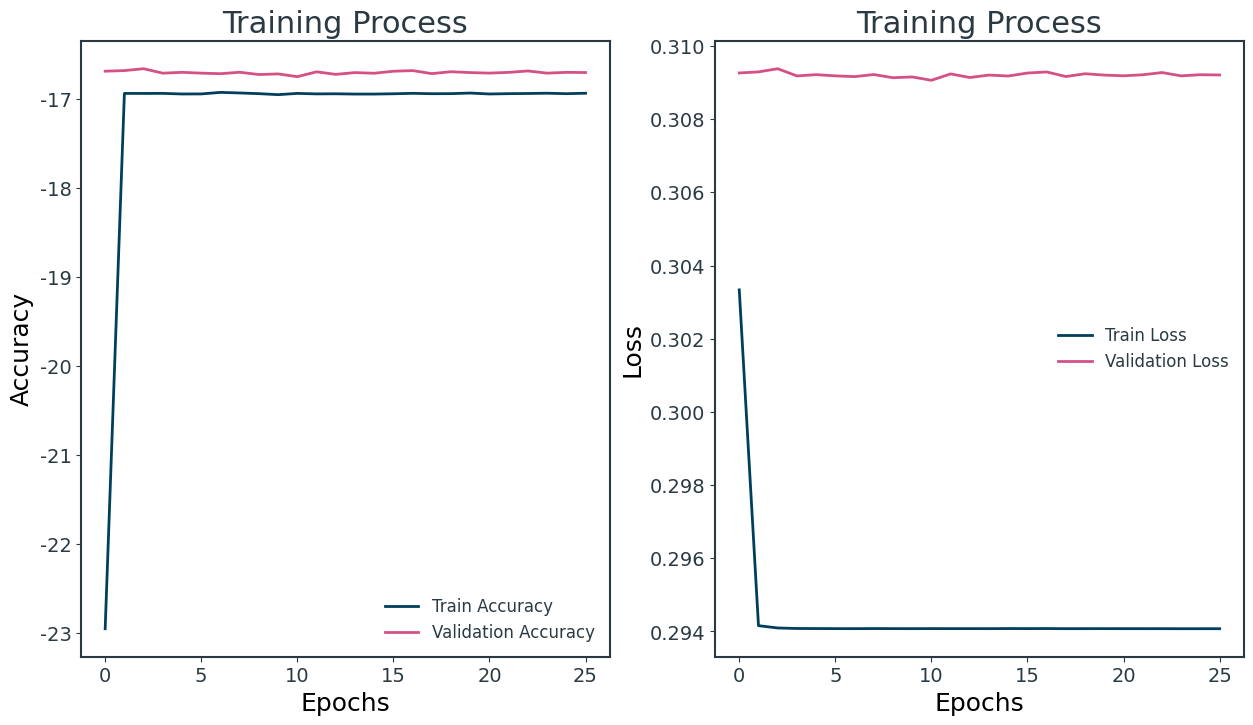

In [31]:
import pandas as pd
import matplotlib.pyplot as plt

history = model.history.history

fig, axes = plt.subplots(1, 2, figsize=(15, 8))

axes[0].plot(pd.DataFrame(history['r2']), label='Train Accuracy')
axes[0].plot(pd.DataFrame(history['val_r2']), label='Validation Accuracy')
axes[0].set_title('Training Process')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

axes[1].plot(pd.DataFrame(history['mae']), label='Train Loss')
axes[1].plot(pd.DataFrame(history['val_mae']), label='Validation Loss')
axes[1].set_title('Training Process')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].legend()

plt.show()


In [32]:
# Truy cập vào lịch sử của mô hình
training_history = model.history.history

# In ra các keys của lịch sử
print(training_history.keys())

# In ra các giá trị của loss và accuracy qua các epochs
print(training_history['loss'])
print(training_history['val_loss'])

dict_keys(['loss', 'mae', 'r2', 'val_loss', 'val_mae', 'val_r2', 'lr'])
[0.30333420634269714, 0.2941575050354004, 0.2940942347049713, 0.2940802574157715, 0.2940783202648163, 0.2940765619277954, 0.2940758764743805, 0.29407799243927, 0.29407668113708496, 0.2940758764743805, 0.2940773367881775, 0.2940763533115387, 0.2940768301486969, 0.2940759062767029, 0.29407837986946106, 0.2940770387649536, 0.294078528881073, 0.29407522082328796, 0.2940761148929596, 0.29407641291618347, 0.29407575726509094, 0.294075071811676, 0.2940753102302551, 0.2940738797187805, 0.29407456517219543, 0.2940744459629059]
[0.30926305055618286, 0.30929166078567505, 0.3093787431716919, 0.30918213725090027, 0.3092164695262909, 0.3091834783554077, 0.3091626763343811, 0.3092193901538849, 0.30913257598876953, 0.30915406346321106, 0.3090624511241913, 0.30923667550086975, 0.30913829803466797, 0.3092052638530731, 0.30917954444885254, 0.30926114320755005, 0.30929020047187805, 0.3091653287410736, 0.30924132466316223, 0.3092049360

In [34]:
from sklearn.metrics import r2_score, mean_absolute_error

# Dự đoán trên tập validation
y_pred = model.predict(X_valid)
print(y_valid.shape,y_pred.shape)
# Tính toán R2 Score
r2 = r2_score(y_valid, y_pred)

# Tính toán MAE
mae = mean_absolute_error(y_valid, y_pred)

print(f"R2 Score: {r2}")
print(f"MAE: {mae}")




16729/16729 [==============================] - 29s 2ms/step
(535312, 1) (535312, 16, 1)


ValueError: Found array with dim 3. None expected <= 2.